In [153]:
import os
import itertools
import warnings
from datetime import datetime as dt
import random
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from collections import defaultdict
from sklearn.metrics import accuracy_score, precision_score, recall_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score, mean_squared_log_error
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.linear_model import LinearRegression
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_breusch_godfrey, acorr_ljungbox, het_white
from scipy.stats import jarque_bera
from statsmodels.tsa.api import VAR
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAXResults
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from arch import arch_model
import pmdarima as pm
from sklearn.model_selection import train_test_split

In [155]:
def plot_time_series(ts1, ts2, ts1_label='ts1', ts2_label='ts2', figsize=(12, 10)):
    # Create subplots
    fig, axs = plt.subplots(nrows=2, ncols=1, figsize=figsize)

    # Plot first time series on first subplot
    axs[0].plot(ts1)
    axs[0].set_xlabel('Date')
    axs[0].set_ylabel('Price')
    axs[0].set_title(ts1_label)

    # Plot second time series on second subplot
    axs[1].plot(ts2)
    axs[1].set_xlabel('Date')
    axs[1].set_ylabel('Price')
    axs[1].set_title(ts2_label)
    
    
def plot_correlogram(x, lags=None, title=None):
    lags = min(10, int(len(x)/5)) if lags is None else lags
    
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 8))
    
    # Residuals plot
    x.plot(ax=axes[0][0], title='Residuals')
    x.rolling(21).mean().plot(ax=axes[0][0], c='k', lw=1)
    q_p = np.max(q_stat(acf(x, nlags=lags), len(x))[1])
    stats = f'Q-Stat: {np.max(q_p):>8.2f}\nADF: {adfuller(x)[1]:>11.2f}'
    axes[0][0].text(x=.02, y=.85, s=stats, transform=axes[0][0].transAxes)
    
    # Probability plot
    probplot(x, plot=axes[0][1])
    mean, var, skew, kurtosis = moment(x, moment=[1, 2, 3, 4])
    s = f'Mean: {mean:>12.2f}\nSD: {np.sqrt(var):>16.2f}\nSkew: {skew:12.2f}\nKurtosis:{kurtosis:9.2f}'
    axes[0][1].text(x=.02, y=.75, s=s, transform=axes[0][1].transAxes)
    
    # ACF and PACF plots
    plot_acf(x=x, lags=lags, zero=False, ax=axes[1][0])
    plot_pacf(x, lags=lags, zero=False, ax=axes[1][1])
    axes[1][0].set_xlabel('Lag')
    axes[1][1].set_xlabel('Lag')
    
    fig.suptitle(title, fontsize=14)
    sns.despine()
    fig.tight_layout()
    fig.subplots_adjust(top=.9)
    
    
    
def split_time_series(data, percent_train):
    n_train = int(len(data) * percent_train)
    train_data = data.iloc[:n_train]
    test_data = data.iloc[n_train:]

    return train_data, test_data


def auto_arima_forecast(series, train_ratio=0.75, n_periods=10):
    n = len(series)
    train_size = int(n * train_ratio)
    train_data, test_data = series[:train_size], series[train_size:]

    pipe = pipeline.Pipeline([
        ("arima", arima.AutoARIMA(stepwise=True, trace=1, error_action="ignore",
                                  seasonal=False,
                                  suppress_warnings=True))
    ])

    pipe.fit(train_data)

    preds, conf_int = pipe.predict(n_periods=n_periods, return_conf_int=True)

    in_sample_preds, in_sample_confint = pipe.predict_in_sample(X=None, return_conf_int=True)

    fig, axes = plt.subplots(3, 1, figsize=(12, 8))
    fig.tight_layout()

    x0 = np.arange(train_size)
    axes[0].plot(x0, train_data, alpha=0.75)
    axes[0].scatter(x0, in_sample_preds, alpha=0.4, marker='x')
    axes[0].fill_between(x0, in_sample_confint[:, 0], in_sample_confint[:, 1],
                         alpha=0.1, color='b')
    axes[0].set_title('Actual train samples vs. in-sample predictions')
    axes[0].set_xlim((0, x0.shape[0]))

    x1 = np.arange(train_size + preds.shape[0])
    axes[1].plot(x1[:train_size], train_data, alpha=0.75)
    axes[1].scatter(x1[train_size:], test_data[:preds.shape[0]], alpha=0.4, marker='x')
    axes[1].fill_between(x1[train_size:], conf_int[:, 0], conf_int[:, 1],
                         alpha=0.1, color='b')
    axes[1].set_title('Actual test samples vs. forecasts')
    axes[1].set_xlim((0, series.shape[0]))

    newly_observed, still_test = test_data[:n_periods], test_data[n_periods:]
    pipe.update(newly_observed, maxiter=10)

    new_preds = pipe.predict(still_test.shape[0])

    x2 = np.arange(series.shape[0])
    n_trained_on = train_size + newly_observed.shape[0]

    axes[2].plot(x2[:train_size], train_data, alpha=0.75)
    axes[2].plot(x2[train_size:n_trained_on], newly_observed, alpha=0.75, c='orange')
    axes[2].scatter(x2[n_trained_on:], still_test, alpha=0.4, marker='x')
    axes[2].set_title('Actual test samples vs. forecasts')
    axes[2].set_xlim((0, series.shape[0]))

    plt.show()
    
    return in_sample_preds


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-30941.489, Time=0.52 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-30959.402, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-30957.600, Time=0.09 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-30957.323, Time=0.11 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-30954.881, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-31013.470, Time=0.23 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-31013.474, Time=0.49 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-31012.877, Time=0.39 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-31091.516, Time=0.51 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-31208.714, Time=0.59 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-31231.280, Time=0.83 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-32464.853, Time=0.77 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-32711.958, Time=0.76 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-30951.503, Time=0.34 sec
 ARIM

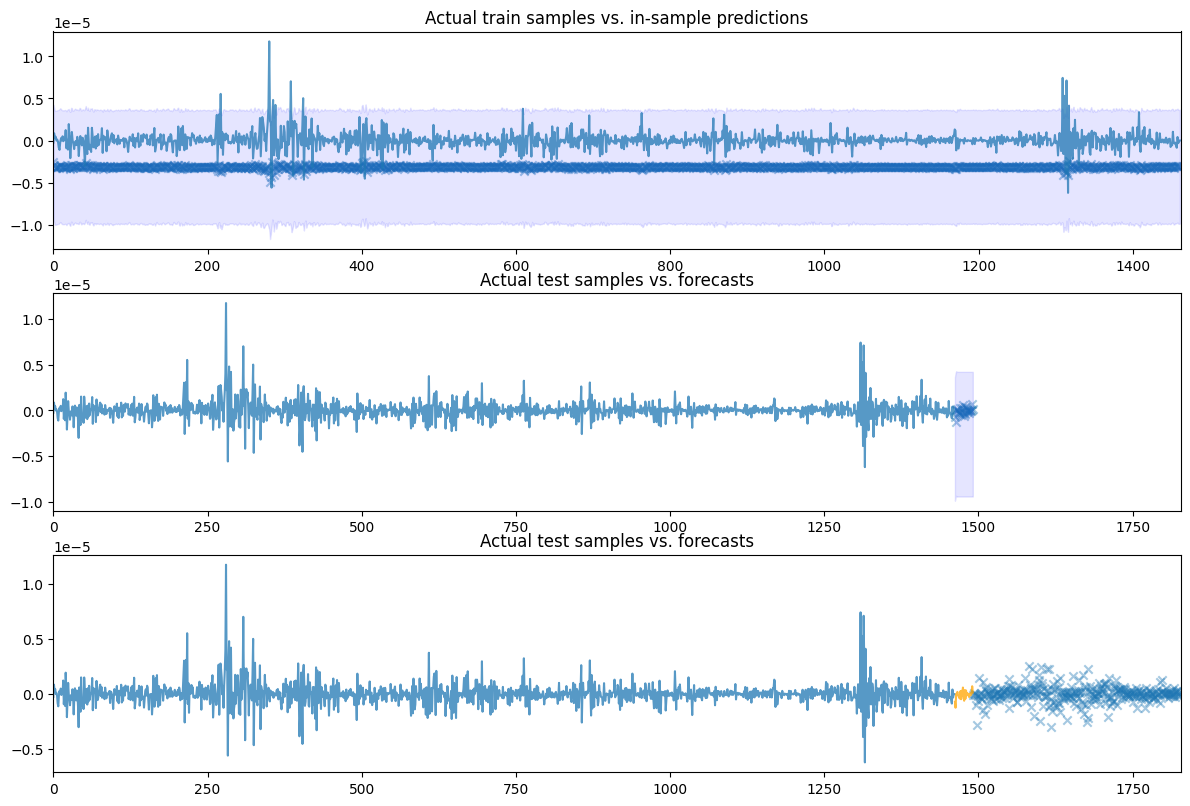

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-28408.352, Time=0.58 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-28358.372, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-28402.165, Time=0.21 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-28397.592, Time=0.10 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-28402.150, Time=0.45 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-28351.513, Time=0.16 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=-28353.485, Time=0.71 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=-28410.712, Time=0.26 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=-28401.739, Time=0.59 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=-28408.697, Time=0.30 sec
 ARIMA(2,0,4)(0,0,0)[0]             : AIC=-28415.469, Time=0.87 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=-28401.563, Time=0.76 sec
 ARIMA(3,0,4)(0,0,0)[0]             : AIC=-28413.339, Time=1.01 sec
 ARIMA(2,0,5)(0,0,0)[0]             : AIC=-28407.381, Time=1.07 sec
 ARIM

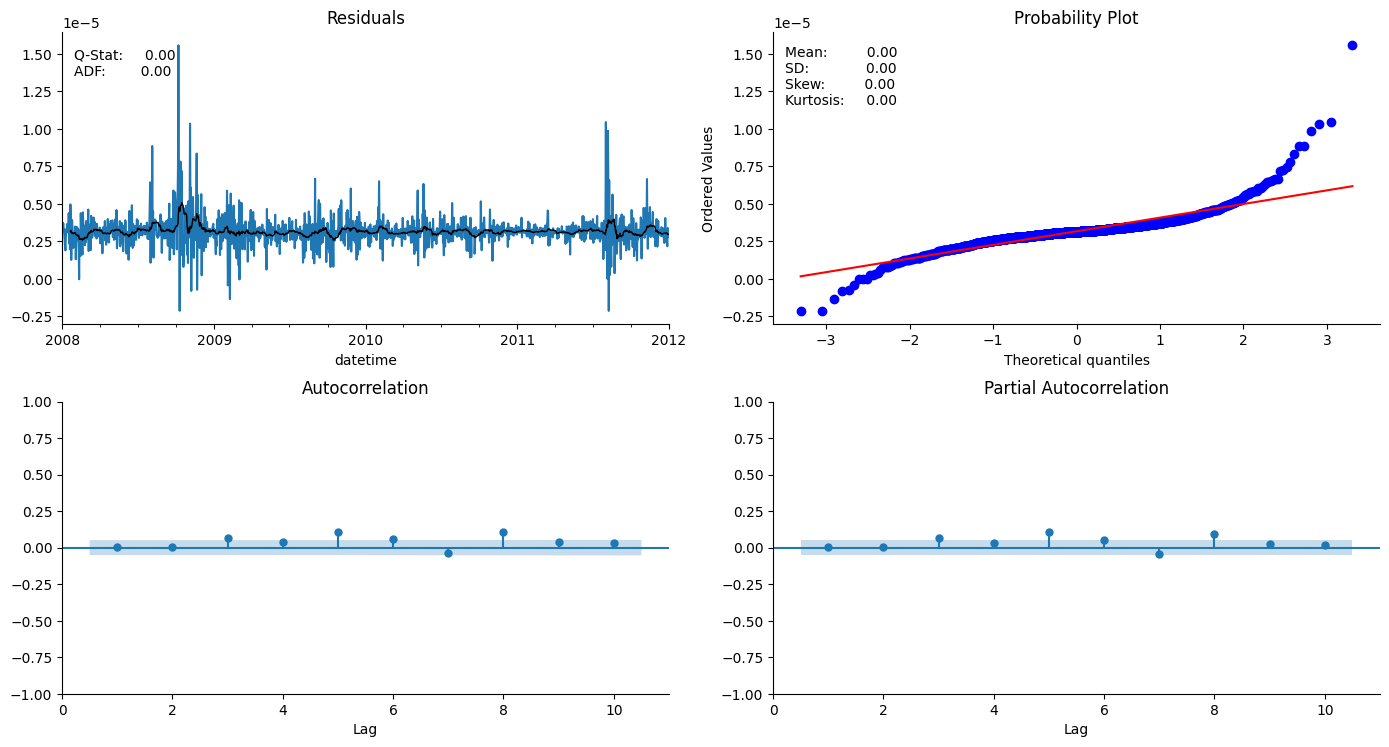

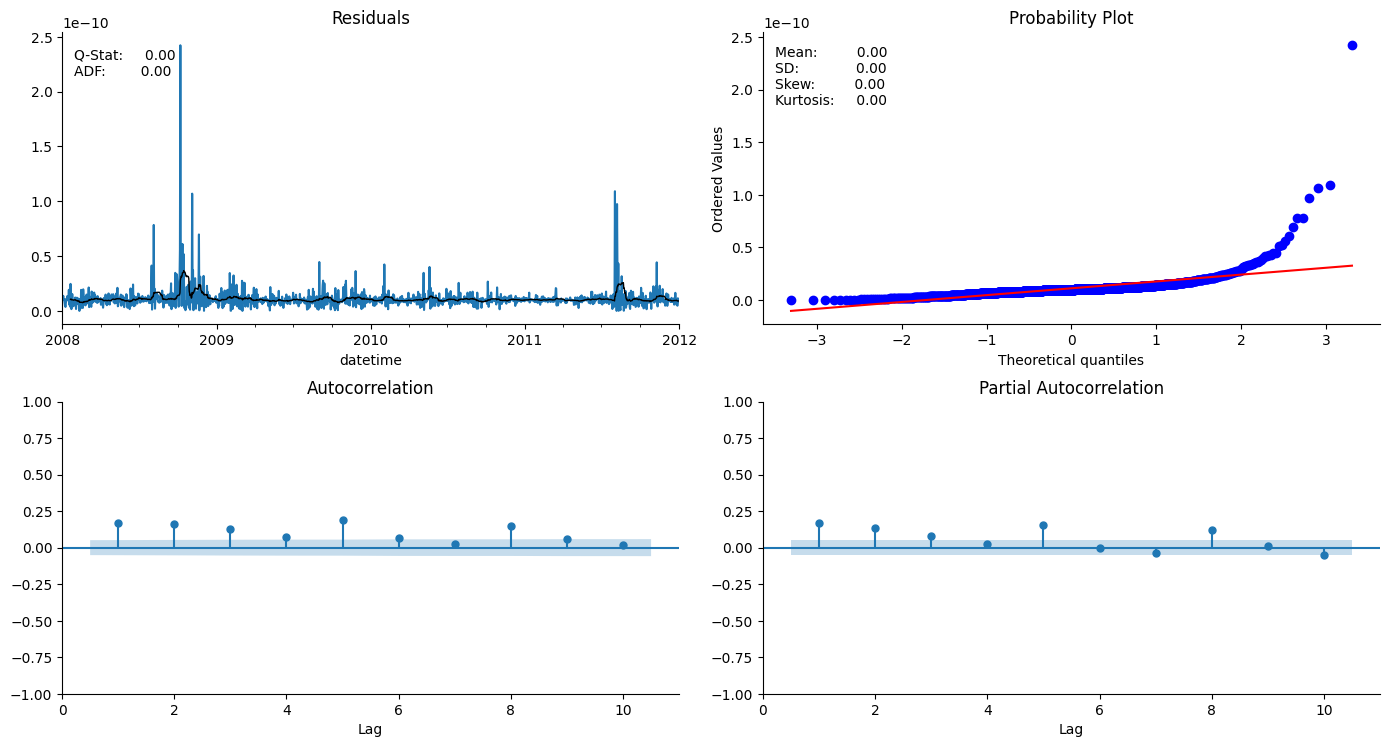

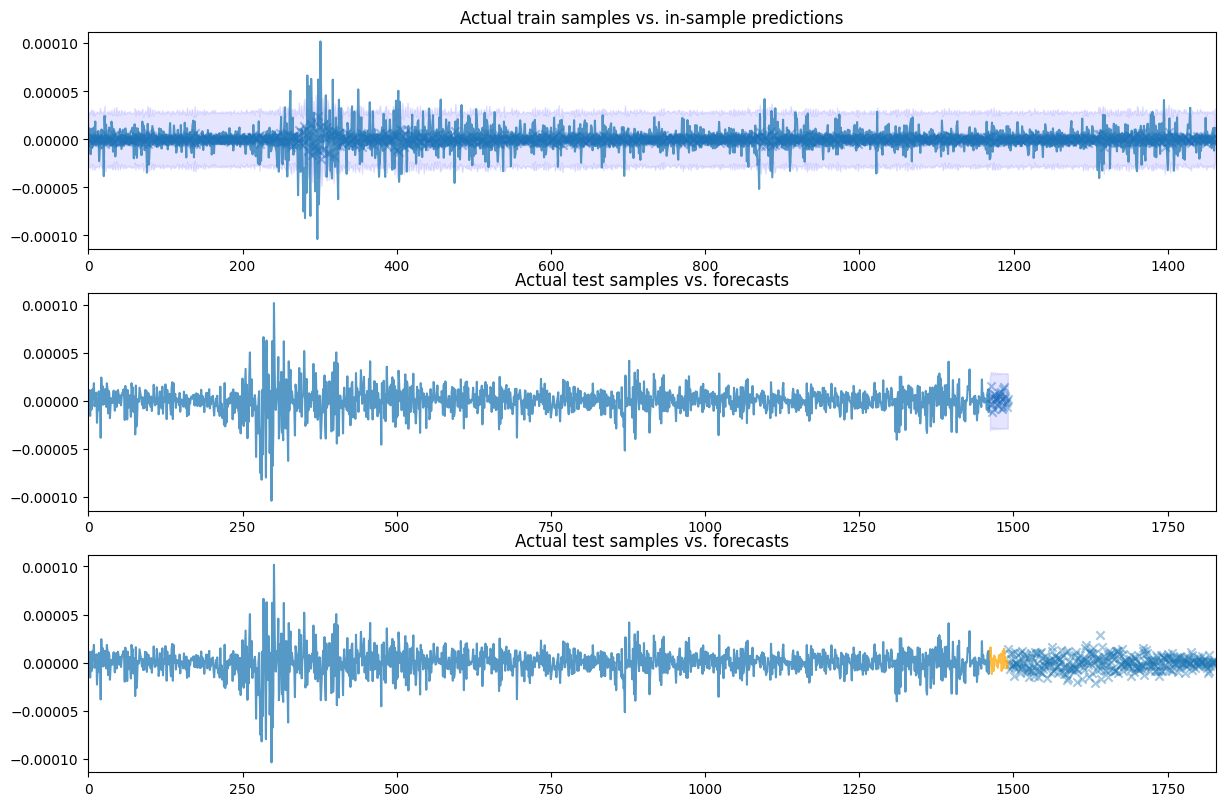

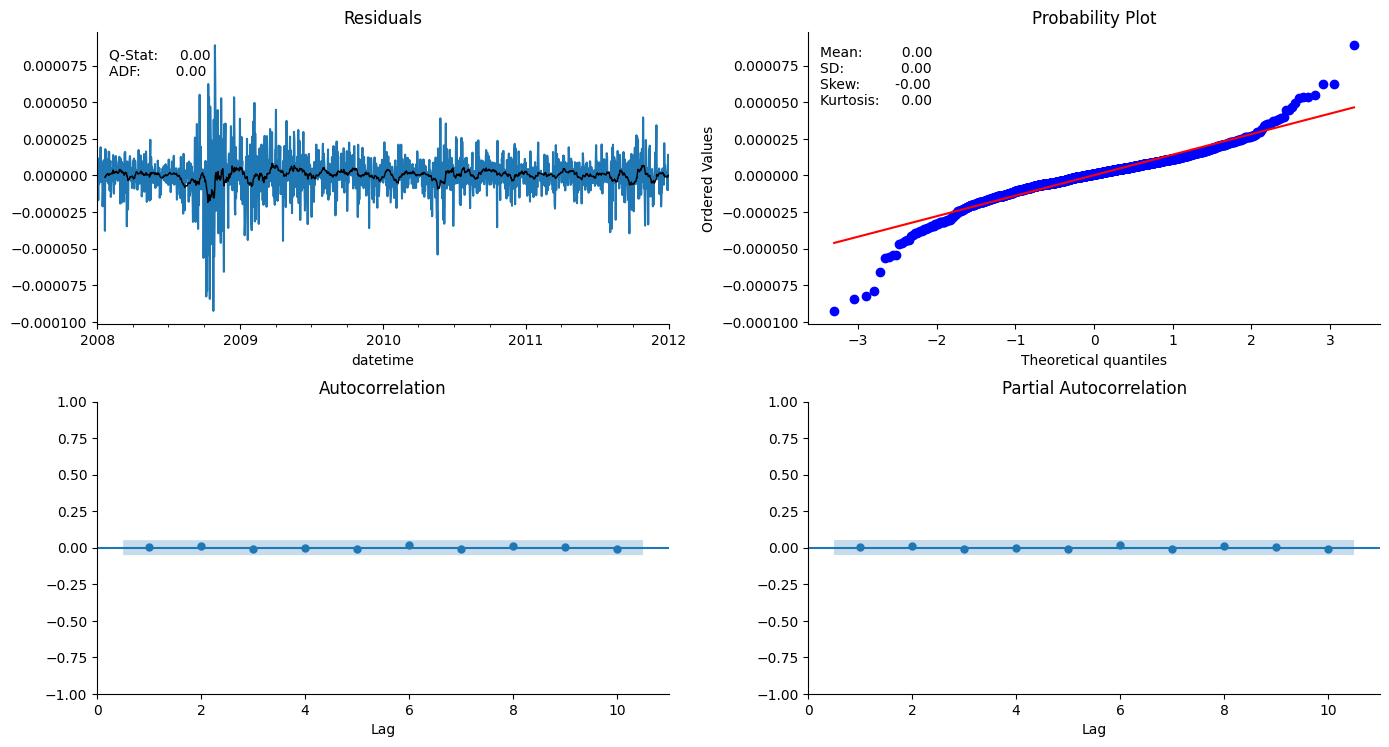

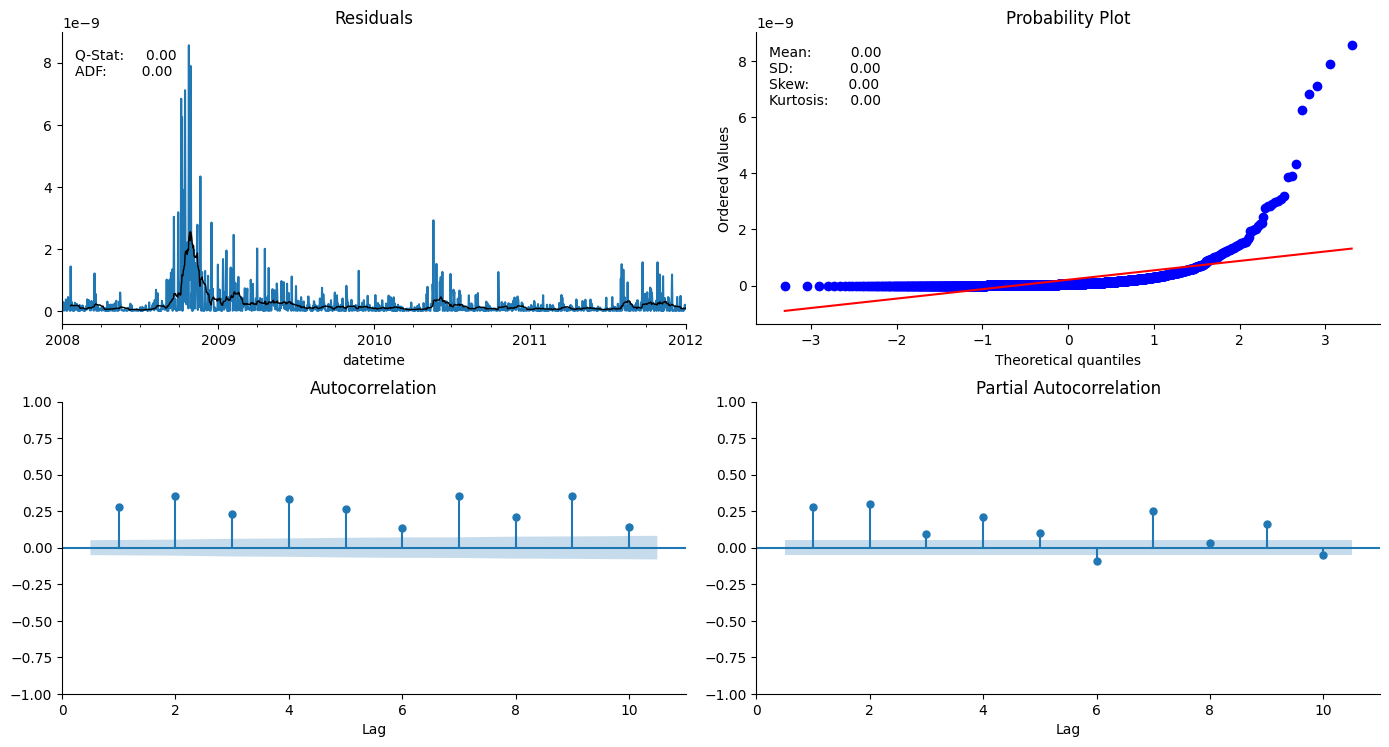

In [156]:
rt_daily = pd.read_csv('rt_daily.csv', index_col=0, parse_dates=True)
rt_1 = rt_daily['ts1']
rt_2 = rt_daily['ts2']
train_data_1, test_data_1 = train_test_split(rt_1, test_size=0.2, shuffle=False)
train_data_2, test_data_2 = train_test_split(rt_2, test_size=0.2, shuffle=False)

#fit arima model to ts1 and ts2 and plots residuals and squared residuals
prediction_1 = auto_arima_forecast(rt_1, train_ratio=0.80, n_periods=30)
resid_1 = train_data_1 - prediction_1
plot_correlogram(resid_1, lags=None, title=None)
plot_correlogram(resid_1.pow(2), lags=None, title=None)
prediction_2 = auto_arima_forecast(rt_2, train_ratio=0.80, n_periods=30)
resid_2 = train_data_2 - prediction_2
plot_correlogram(resid_2, lags=None, title=None)
plot_correlogram(resid_2.pow(2), lags=None, title=None)

VAR

In [158]:
train_data.shape

(1462, 2)

In [162]:
from sklearn.metrics import mean_absolute_percentage_error
from statsmodels.tsa.api import VAR
train_data, test_data = train_test_split(rt_daily, test_size=0.2, shuffle=False)



model = VAR(train_data)
results = model.fit(maxlags=3)
lag_order = results.k_ar
fcst = results.forecast(train_data.values[-lag_order:], test_data.shape[0])
model_accuracy = 1 - mean_absolute_percentage_error(test_data, fcst)
print(model_accuracy)

-2213038.996704297


-2213038.996704297


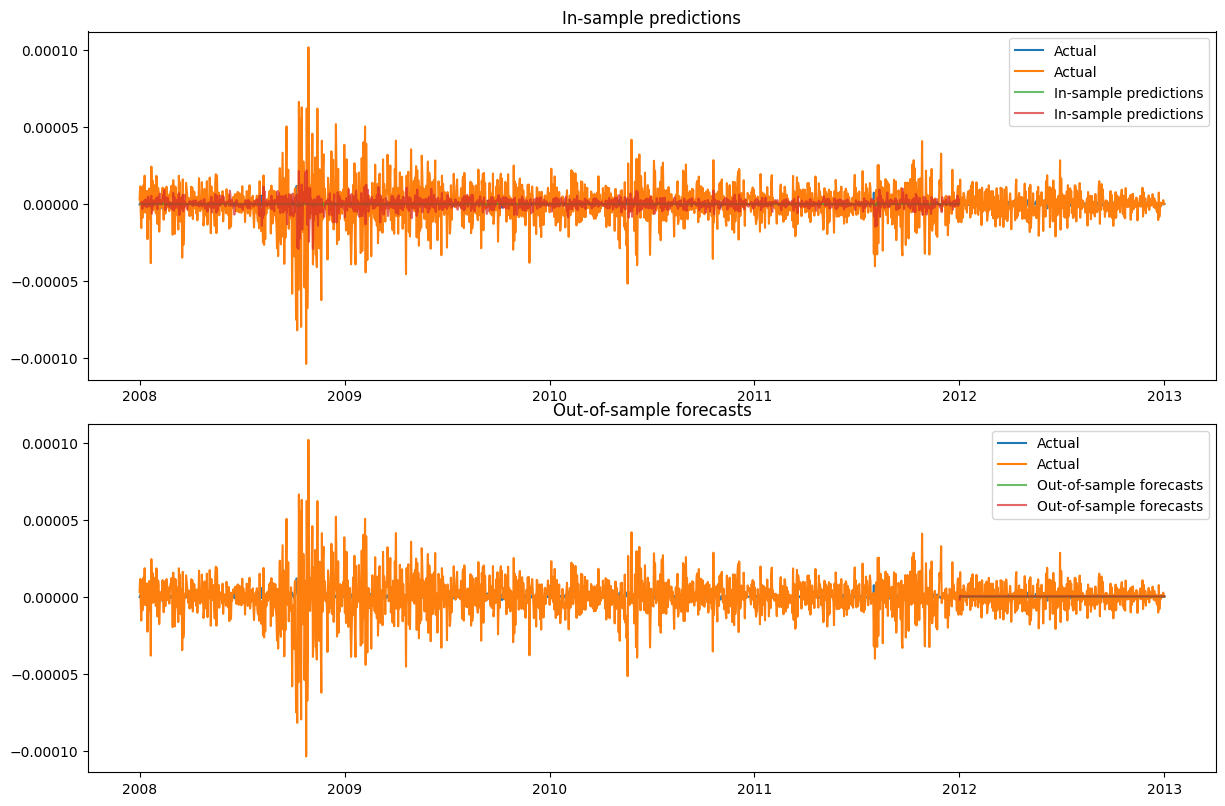

In [164]:
train_data, test_data = train_test_split(rt_daily, test_size=0.2, shuffle=False)

# Fit the VAR model
model = VAR(train_data)
results = model.fit(maxlags=3)

# Generate in-sample predictions
in_sample_preds = results.fittedvalues

# Generate out-of-sample forecasts
lag_order = results.k_ar
n_periods = test_data.shape[0]
fcst = results.forecast(train_data.values[-lag_order:], n_periods)

# Calculate accuracy
model_accuracy = 1 - mean_absolute_percentage_error(test_data, fcst)
print(model_accuracy)

# Plot the results
fig, axes = plt.subplots(2, 1, figsize=(12, 8))
fig.tight_layout()

x_train = np.arange(len(train_data))
x_test = np.arange(len(train_data), len(train_data) + len(test_data))

# In-sample predictions
axes[0].plot(rt_daily.index, rt_daily, label="Actual")
axes[0].plot(in_sample_preds.index, in_sample_preds, label="In-sample predictions", alpha=0.7)
axes[0].legend()
axes[0].set_title("In-sample predictions")

# Out-of-sample forecasts
axes[1].plot(rt_daily.index, rt_daily, label="Actual")
axes[1].plot(test_data.index, fcst, label="Out-of-sample forecasts", alpha=0.7)
axes[1].legend()
axes[1].set_title("Out-of-sample forecasts")

plt.show()

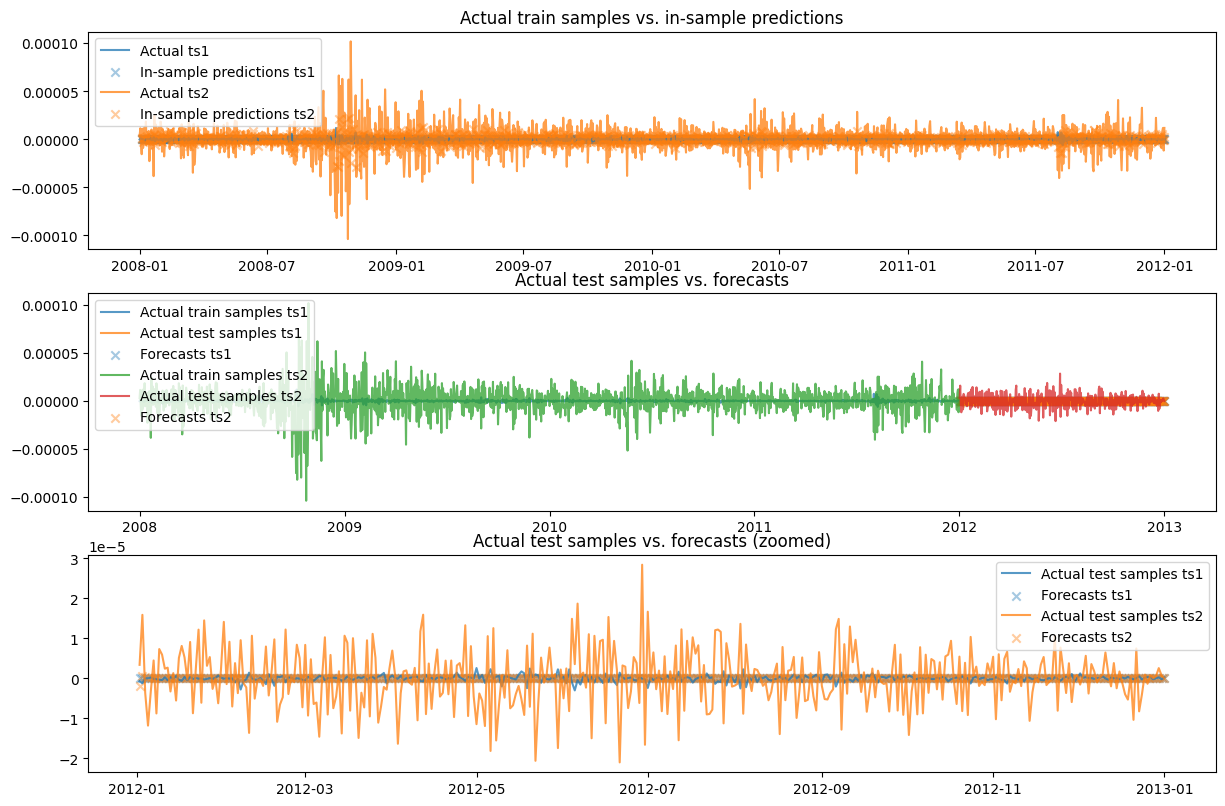

In [168]:
fig, axes = plt.subplots(3, 1, figsize=(12, 8))
fig.tight_layout()

# In-sample predictions
for col in in_sample_preds.columns:
    axes[0].plot(train_data.index, train_data[col], alpha=0.75, label=f"Actual {col}")
    axes[0].scatter(in_sample_preds.index, in_sample_preds[col], alpha=0.4, marker='x', label=f"In-sample predictions {col}")
axes[0].set_title("Actual train samples vs. in-sample predictions")
axes[0].legend()

# Out-of-sample forecasts
for col in train_data.columns:
    axes[1].plot(train_data.index, train_data[col], alpha=0.75, label=f"Actual train samples {col}")
    axes[1].plot(test_data.index, test_data[col], alpha=0.75, label=f"Actual test samples {col}")
    axes[1].scatter(test_data.index, fcst[:, train_data.columns.get_loc(col)], alpha=0.4, marker='x', label=f"Forecasts {col}")
axes[1].set_title("Actual test samples vs. forecasts")
axes[1].legend()

# Out-of-sample forecasts with a focus on test samples
for col in test_data.columns:
    axes[2].plot(test_data.index, test_data[col], alpha=0.75, label=f"Actual test samples {col}")
    axes[2].scatter(test_data.index, fcst[:, test_data.columns.get_loc(col)], alpha=0.4, marker='x', label=f"Forecasts {col}")
axes[2].set_title("Actual test samples vs. forecasts (zoomed)")
axes[2].legend()

plt.show()

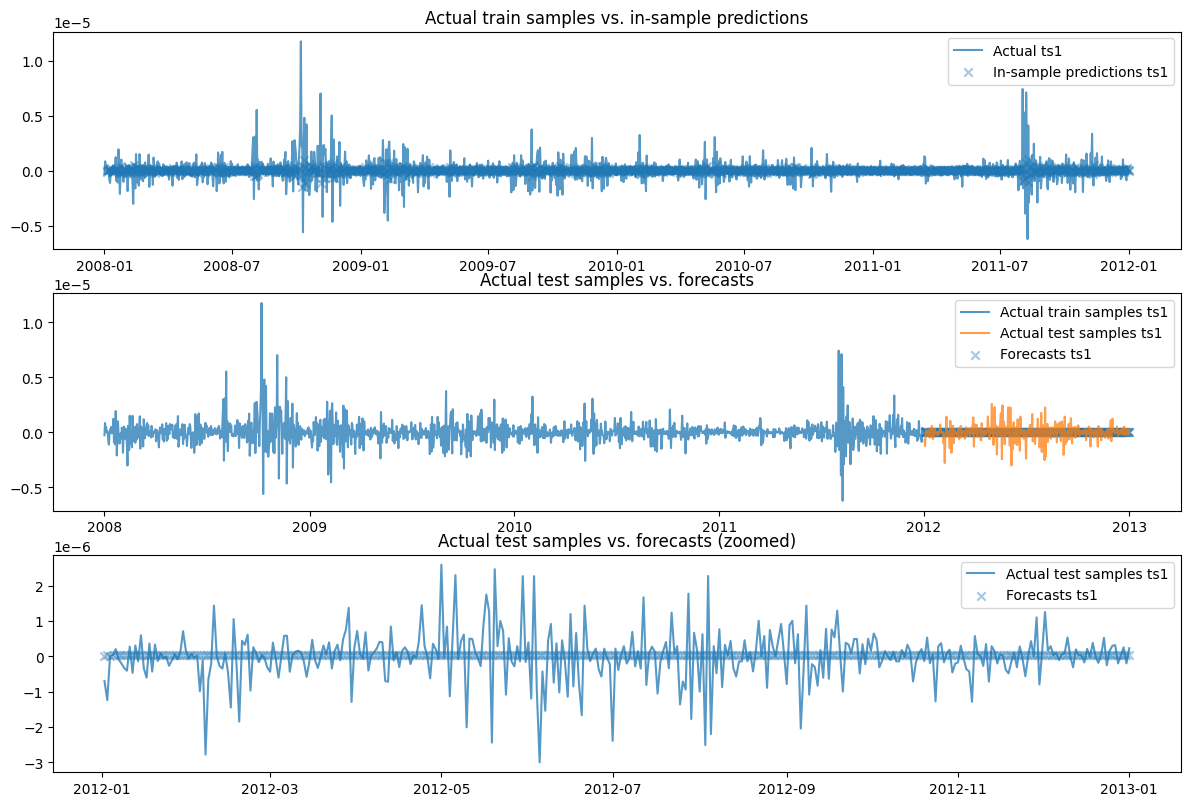

In [170]:
import matplotlib.pyplot as plt

def plot_var_predictions(train_data, test_data, in_sample_preds, fcst, selected_series=None):
    if selected_series is None:
        selected_series = train_data.columns

    fig, axes = plt.subplots(3, 1, figsize=(12, 8))
    fig.tight_layout()

    # In-sample predictions
    for col in selected_series:
        axes[0].plot(train_data.index, train_data[col], alpha=0.75, label=f"Actual {col}")
        axes[0].scatter(in_sample_preds.index, in_sample_preds[col], alpha=0.4, marker='x', label=f"In-sample predictions {col}")
    axes[0].set_title("Actual train samples vs. in-sample predictions")
    axes[0].legend()

    # Out-of-sample forecasts
    for col in selected_series:
        axes[1].plot(train_data.index, train_data[col], alpha=0.75, label=f"Actual train samples {col}")
        axes[1].plot(test_data.index, test_data[col], alpha=0.75, label=f"Actual test samples {col}")
        axes[1].scatter(test_data.index, fcst[:, train_data.columns.get_loc(col)], alpha=0.4, marker='x', label=f"Forecasts {col}")
    axes[1].set_title("Actual test samples vs. forecasts")
    axes[1].legend()

    # Out-of-sample forecasts with a focus on test samples
    for col in selected_series:
        axes[2].plot(test_data.index, test_data[col], alpha=0.75, label=f"Actual test samples {col}")
        axes[2].scatter(test_data.index, fcst[:, test_data.columns.get_loc(col)], alpha=0.4, marker='x', label=f"Forecasts {col}")
    axes[2].set_title("Actual test samples vs. forecasts (zoomed)")
    axes[2].legend()

    plt.show()

# Example usage:
plot_var_predictions(train_data, test_data, in_sample_preds, fcst, selected_series=["ts1"])


 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -48.33      -48.32   1.027e-21      -48.32
1       -49.13      -49.11   4.586e-22      -49.13
2       -49.50      -49.47   3.172e-22      -49.49
3       -49.66      -49.62   2.699e-22      -49.65
4       -49.81      -49.74   2.343e-22      -49.78
5       -49.89      -49.81   2.149e-22      -49.86
6       -49.92      -49.83   2.093e-22      -49.88
7       -49.96      -49.86   2.006e-22      -49.92
8       -49.99      -49.87   1.955e-22      -49.94
9       -50.00     -49.87*   1.927e-22      -49.95
10      -50.00      -49.85   1.927e-22      -49.95
11      -50.01      -49.85   1.908e-22      -49.95
12      -50.02      -49.84   1.894e-22      -49.95
13      -50.03      -49.84   1.879e-22      -49.96
14      -50.05      -49.84   1.841e-22      -49.97
15      -50.07      -49.86   1.790e-22      -49.99
16      -50.08      -49.85   1.

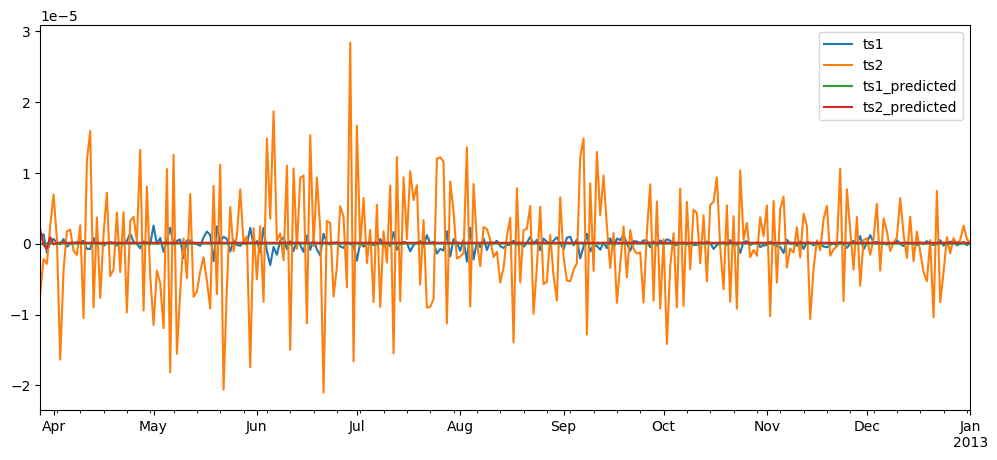

In [169]:
from statsmodels.tsa.api import VAR
from statsmodels.tsa.statespace.varmax import VARMAX

def var_forecast(df, train_periods, forecast_periods):
    train_df = df[:-forecast_periods]
    test_df = df[-forecast_periods:]

    model = VAR(train_df.diff()[1:])

    sorted_order = model.select_order(maxlags=20)
    print(sorted_order.summary())

    var_model = VARMAX(train_df, order=(4, 0), enforce_stationarity=True)
    fitted_model = var_model.fit(disp=False)
    print(fitted_model.summary())

    predict = fitted_model.get_prediction(start=len(train_df), end=len(train_df) + forecast_periods - 1)

    predictions = predict.predicted_mean
    predictions.columns = [f"{col}_predicted" for col in df.columns]

    test_vs_pred = pd.concat([test_df, predictions], axis=1)
    test_vs_pred.plot(figsize=(12, 5))


    return test_vs_pred

result = var_forecast(rt_daily, train_periods=len(rt_daily) - 12, forecast_periods=280)

In [84]:
# plt.plot(prediction)
clean = pd.read_csv('clean_df.csv', index_col=0, parse_dates=True)
rt_nl = clean/clean.shift(1)

In [96]:
rt_nl.dropna(inplace=True)
rt_1_no_d = rt_nl['ts1'].resample('D').mean()

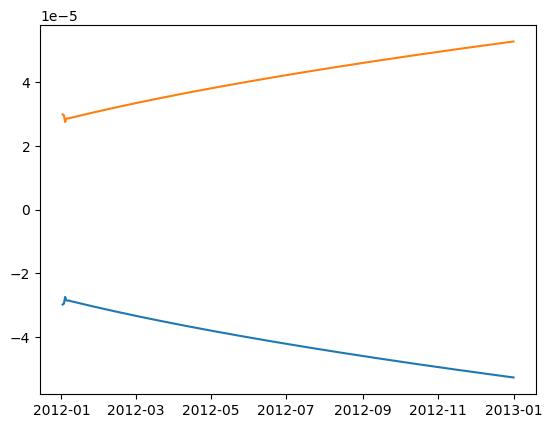

In [136]:
cfg_list = [(p, d, q) for p in range(4) for d in range(2) for q in range(4)]
cfg = cfg_list[5] 
data = train_data.clip(lower=train_data.quantile(.5),
                           upper=train_data.quantile(.60))

order = (2, 1, 2)
model = ARIMA(data, order=order)
model_fit = model.fit()

# model_fit.plot_diagnostics(figsize=(15, 12))

prediction = model_fit.get_prediction(start=len(train_data), end=len(train_data) + len(test_data) - 1)
predicted_interval = prediction.conf_int()

plt.plot(predicted_interval)
plt.show()


In [137]:
import pmdarima as pm
from pmdarima import pipeline
from pmdarima import model_selection
from pmdarima import preprocessing as ppc
from pmdarima import arima
from matplotlib import pyplot as plt

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-30941.489, Time=0.57 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-30959.402, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-30957.600, Time=0.10 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-30957.323, Time=0.12 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-30954.881, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-31013.470, Time=0.23 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-31013.474, Time=0.48 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-31012.877, Time=0.39 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-31091.516, Time=0.52 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-31208.714, Time=0.58 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-31231.280, Time=0.82 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-32464.853, Time=0.80 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-32711.958, Time=0.77 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-30951.503, Time=0.35 sec
 ARIM

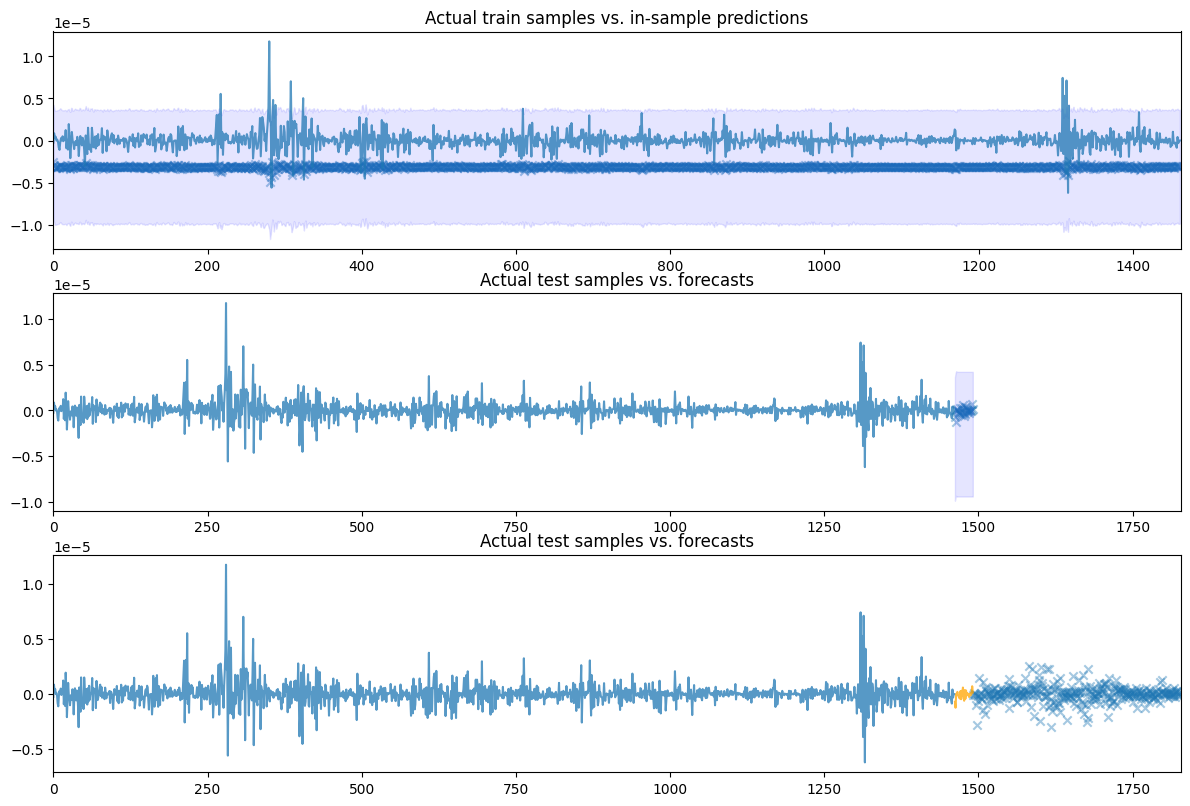

In [144]:

# Example usage:
prediction = auto_arima_forecast(rt_1, train_ratio=0.80, n_periods=30)

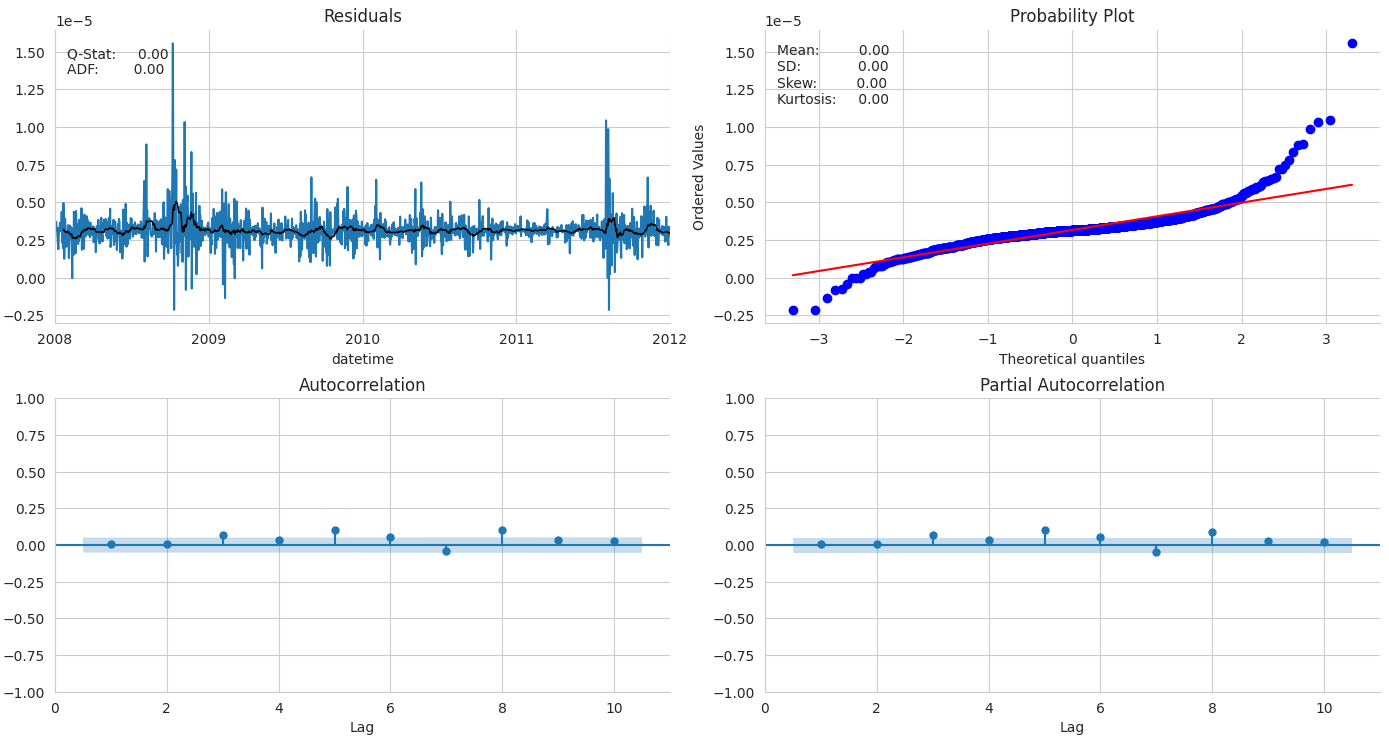

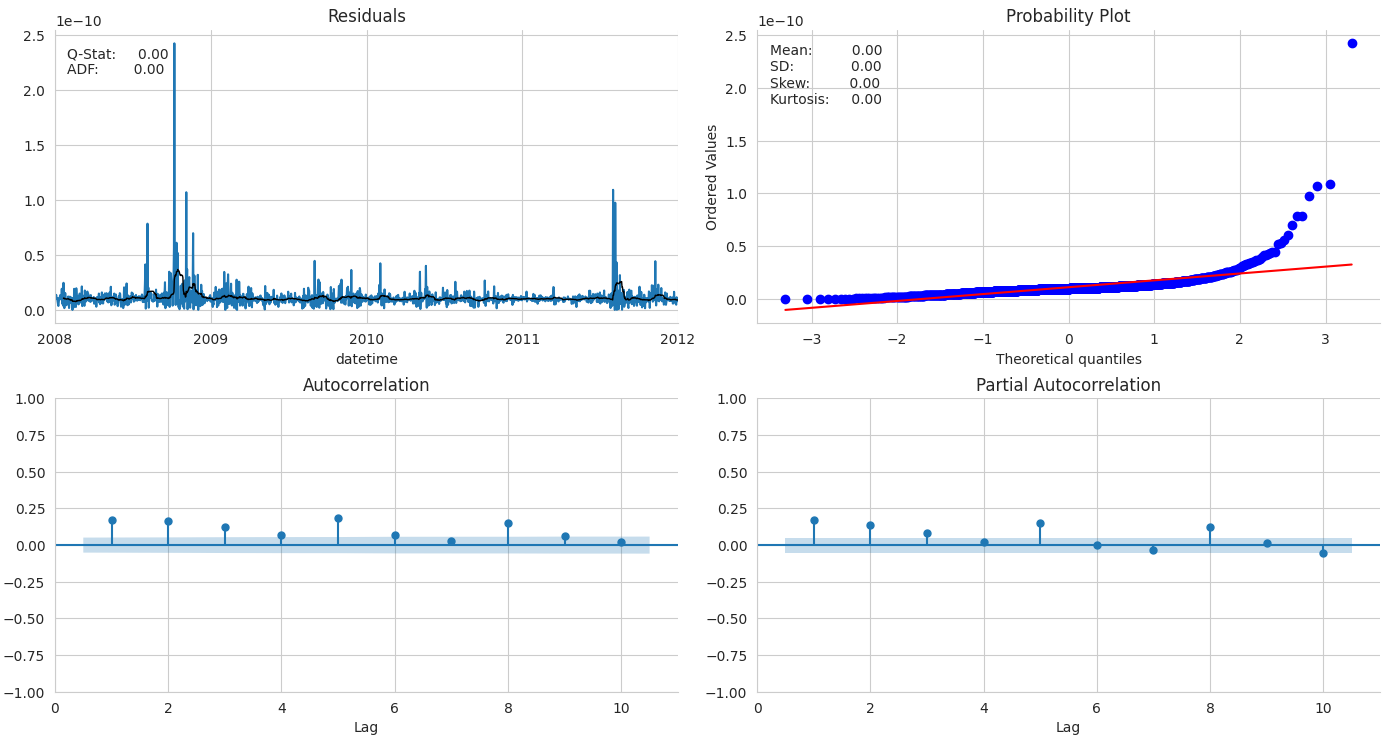

In [152]:
resid = train_data - prediction
plot_correlogram(resid, lags=None, title=None)
plot_correlogram(resid.pow(2), lags=None, title=None)

In [150]:
import statsmodels.tsa.api as tsa
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, q_stat, adfuller
from scipy.stats import probplot, moment
from sklearn.metrics import mean_squared_error

AttributeError: 'ARIMAResults' object has no attribute 'plot_predict'

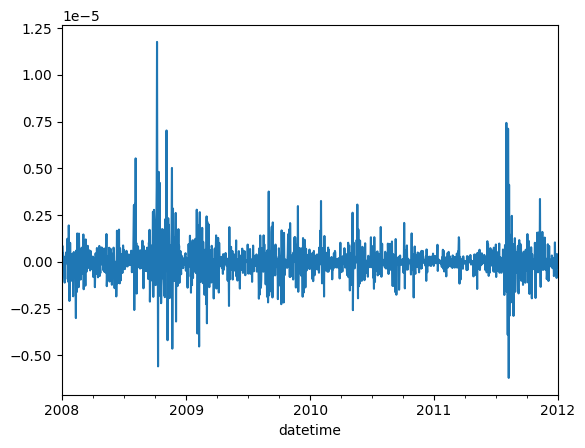

In [126]:
res = ARIMA(train_data, order =  (2, 0,2) ).fit()
fig, ax = plt.subplots()
ax = train_data.plot(ax=ax)
fig = res.plot_predict(dynamic=False, ax=ax, plot_insample=False)
plt.show()

In [105]:
trainsize = 120  # 10 years
data = rt_1.clip(lower=rt_1.quantile(.05),
                           upper=rt_1.quantile(.95))
T = len(rt_1)
p=2
q=2
results = {}
print(f'{p} | {q}')
result = []
for s, t in enumerate(range(trainsize, T-1)):
    train_set = data.iloc[s: t]
    test_set = data.iloc[t+1]  # 1-step ahead forecast
    model = ARIMA(train_set, order = (p,0,q)).fit()
    forecast = model.forecast(horizon=1)
    result.append([(test_set-mu)**2, var])
df = pd.DataFrame(result, columns=['y_true', 'y_pred'])
results[(p, q)] = np.sqrt(mean_squared_error(df.y_true, df.y_pred))

2 | 2


KeyboardInterrupt: 

In [98]:
from arch import arch_model
from arch.univariate import ConstantMean, GARCH, Normal

best_p, best_q = 5,5,
am = ConstantMean(rt_1_no_d.clip(lower=rt_1_no_d.quantile(.05),
                                      upper=rt_1_no_d.quantile(.95)))
am.volatility = GARCH(best_p, 1, best_q)
am.distribution = Normal()
best_model = am.fit(update_freq=5)
print(best_model.summary())
# fig = best_model.plot()
# fig.set_size_inches(12, 8)
# fig.tight_layout();

Inequality constraints incompatible    (Exit mode 4)
            Current function value: -23554.627325899608
            Iterations: 1
            Function evaluations: 14
            Gradient evaluations: 1
                   Constant Mean - GJR-GARCH Model Results                    
Dep. Variable:                    ts1   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                  GJR-GARCH   Log-Likelihood:                23554.6
Distribution:                  Normal   AIC:                          -47083.3
Method:            Maximum Likelihood   BIC:                          -47011.6
                                        No. Observations:                 1828
Date:                Sat, Apr 01 2023   Df Residuals:                     1827
Time:                        03:50:35   Df Model:                            1
                               Mean Model                               
        

C:\Users\Jordan Moshcovitis\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


In [80]:
# evaluate an ARIMA model for a given order (p,d,q) and return RMSE
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    X = X.astype('float32')
    train_size = int(len(X) * 0.50)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # print(f'Training data length: {len(history)}')
    # make predictions
    predictions = list()
    for t in range(len(test)):
        print(f'Testing data point: {t}')
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        print(f'Evaluating p: {p}')
        for d in d_values:
            print(f'Evaluating d: {d}')
            for q in q_values:
                order = (p,d,q)
                print(f'Evaluating q: {q}')
                try:
                    rmse = evaluate_arima_model(dataset, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE=%.3f' % (order, rmse))
                except Exception as e:
                    print(f'Error evaluating ARIMA{order}: {e}')
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

# load dataset

# evaluate parameters
p_values = range(0,13)
d_values = range(0, 4)
q_values = range(0, 13)
warnings.filterwarnings("ignore")
evaluate_models(rt_2.values, p_values, d_values, q_values)

Evaluating p: 0
Evaluating d: 0
Evaluating q: 0
Testing data point: 0
Testing data point: 1
Testing data point: 2
Testing data point: 3
Testing data point: 4
Testing data point: 5
Testing data point: 6
Testing data point: 7
Testing data point: 8
Testing data point: 9
Testing data point: 10
Testing data point: 11
Testing data point: 12
Testing data point: 13
Testing data point: 14
Testing data point: 15
Testing data point: 16
Testing data point: 17
Testing data point: 18
Testing data point: 19
Testing data point: 20
Testing data point: 21
Testing data point: 22
Testing data point: 23
Testing data point: 24
Testing data point: 25
Testing data point: 26
Testing data point: 27
Testing data point: 28
Testing data point: 29
Testing data point: 30
Testing data point: 31
Testing data point: 32
Testing data point: 33
Testing data point: 34
Testing data point: 35
Testing data point: 36
Testing data point: 37
Testing data point: 38
Testing data point: 39
Testing data point: 40
Testing data point:

KeyboardInterrupt: 

In [ ]:
T = len(rt_1)
results = {}
for p in range(1, 5):
    for q in range(1, 5):
        print(f'{p} | {q}')
        result = []
        for s, t in enumerate(range(trainsize, T-1)):
            train_set = data.iloc[s: t]
            test_set = data.iloc[t+1]  # 1-step ahead forecast
            model = arch_model(y=train_set, p=p, q=q).fit(disp='off')
            forecast = model.forecast(horizon=1)
            mu = forecast.mean.iloc[-1, 0]
            var = forecast.variance.iloc[-1, 0]
            result.append([(test_set-mu)**2, var])
        df = pd.DataFrame(result, columns=['y_true', 'y_pred'])
        results[(p, q)] = np.sqrt(mean_squared_error(df.y_true, df.y_pred))

In [59]:
import pmdarima as pm

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-27905.189, Time=1.17 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=5189.639, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.45 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.23 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-18512.964, Time=0.97 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-41978.652, Time=0.36 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-37810.997, Time=0.16 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.34 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=-37712.718, Time=0.25 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.21 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=1.85 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=nan sec

Best model:  ARIMA(2,0,1)(0,0,0)[0]          
Total fit time: 6.516 seconds


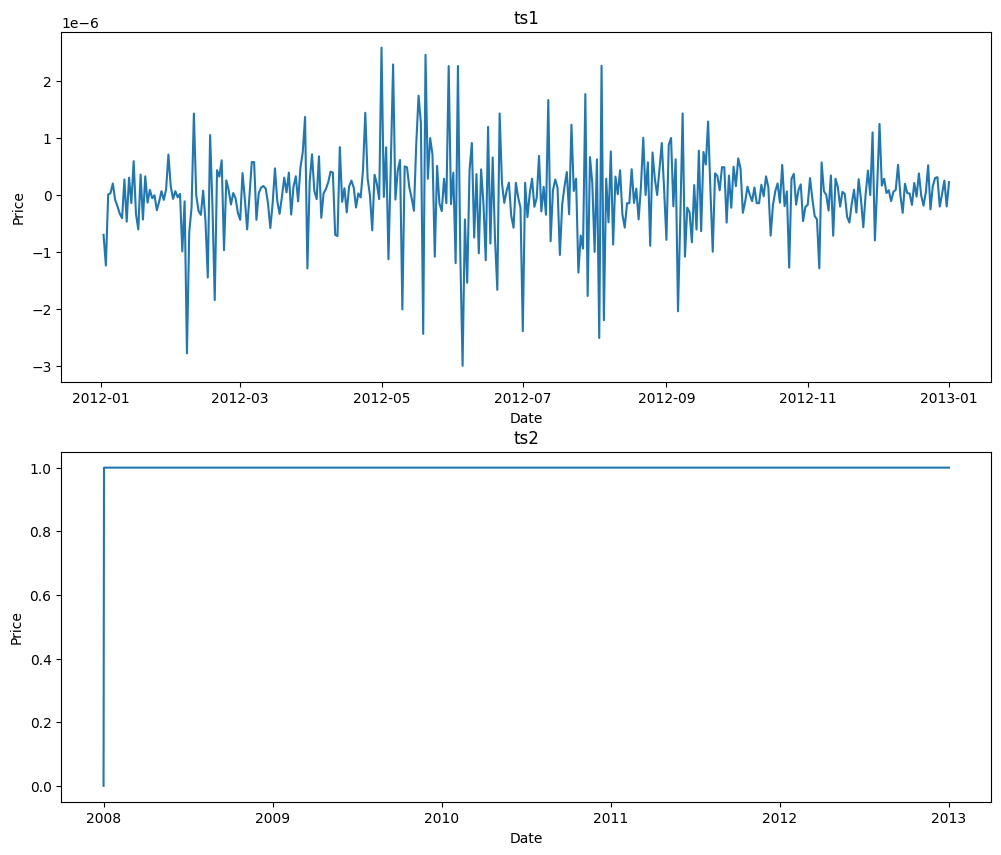

In [99]:
model = pm.auto_arima(rt_1_no_d, seasonal=False, trace=True, error_action='ignore', suppress_warnings=True, stepwise=True)
model.get_params()
model.fit(rt_1_no_d)
in_sample_predictions = model.predict_in_sample()
# Evaluate the model on the test data
# predictions = model.predict(n_periods=len(test_data))
# Do something with the predictions
# plot the predictions for validation set
plot_time_series(test_data, in_sample_predictions)


In [47]:
from pmdarima.model_selection import RollingForecastCV
rfcv = RollingForecastCV(
    h=170,  # forecast horizon
    step=30,  # step size
)

In [ ]:
def grid_search(data, cfg_list):
    scores = {}
    models = {}

    for cfg in cfg_list:
        score, model = walk_forward_validation(data, cfg)
        scores[cfg] = score
        models[cfg] = model

    # Calculate mean and standard deviation of scores
    mean_score = np.mean(list(scores.values()))
    std_score = np.std(list(scores.values()))

    # Find the best configuration and model using argmin
    best_cfg = min(scores, key=scores.get)
    best_model = models[best_cfg]
    
    return best_model, scores, models, mean_score, std_score

In [52]:
model_params = []
evaluation_results = []
models = []
# for train_index, test_index in rfcv.split(rt_1_D_train):
#     train_data = rt_1_D_train.iloc[train_index]
#     test_data = rt_1_D_train.iloc[test_index]


# for train_index, test_index in rfcv.split(data):
#     train_data = data.iloc[train_index]
#     test_data = data.iloc[test_index]
#     model = train_model(train_data, config)
#     prediction = model_predict(model, train_data, cfg)
#     predictions.append(prediction)
#     evaluation_result = evaluate(test_data, prediction)
#     evaluation_results.append(evaluation_result)
    
    
    
def grid_search(data, cfg_list):
    scores_and_models = {}
    for cfg in cfg_list:
        score, model = walk_forward_validation(data, cfg)
        scores_and_models[cfg] = {'score': score, 'model': model}
    
    # Calculate mean and standard deviation of scores
    scores = [v['score'] for v in scores_and_models.values()]
    mean_score = np.mean(scores)
    std_score = np.std(scores)
    
    return scores_and_models, mean_score, std_score


def train_model(train, config):
    order = config
    model = ARIMA(train, order=order)
    model_fit = model.fit()
    return model_fit

def model_predict(model, start, end):
    return model.predict(start=start, end=end)

# def evaluate(test_data, prediction):
#     return measure_rmse(test_data, prediction)

def evaluate(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    # msle = mean_squared_log_error(y_true, y_pred)
    return {
        'rmse': rmse,
    }

def walk_forward_validation(data, cfg):
    rfcv = RollingForecastCV(h=170, step=30)
    evaluation_results = []

    for train_index, test_index in rfcv.split(data):
        train_data = data[train_index]
        test_data = data[test_index]
        model_fit = train_model(train_data, cfg)
        prediction = model_predict(model_fit, start=len(train_data), end=len(train_data)+len(test_data)-1)
        evaluation_result = evaluate(test_data, prediction)
        evaluation_results.append(evaluation_result)

    return np.mean(evaluation_results), model_fit




ARIMA model

In [ ]:
model = auto_arima(rt_1_D_train, seasonal=False, trace=True, error_action='ignore', suppress_warnings=True, stepwise=True)
model.get_params()
in_sample_predictions = model.predict_in_sample()
# model.fit(rt_1_D_train)
# Evaluate the model on the test data
# predictions = model.predict(n_periods=len(test_data), exogenous=test_data.drop('target_variable', axis=1))
# Do something with the predictions
#plot the predictions for validation set
# plot_time_series(rt_1_D_train, in_sample_predictions)




#Preparing data for the ARIMAX Model, seperating endogeneous and exogenous variables
X_train_ARIMA=X_train.drop(['MSFT_pred(t-1)'], axis = 'columns' ).dropna()
X_validation_ARIMA=X_validation.drop(['MSFT_pred(t-1)'], axis = 'columns' ).dropna()
tr_len = len(X_train_ARIMA)
te_len = len(X_validation_ARIMA)
to_len = len (X)

from statsmodels.tsa.arima_model import ARIMA
#from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.metrics import mean_squared_error

modelARIMA=ARIMA(endog=Y_train,exog=X_train_ARIMA,order=[1,0,0])
#modelARIMA= SARIMAX(Y_train,order=(1,1,0),seasonal_order=[1,0,0,0],exog = X_train_ARIMA)

model_fit = modelARIMA.fit()
#print(model_fit.summary())

error_Training_ARIMA = mean_squared_error(Y_train, model_fit.fittedvalues)
predicted = model_fit.predict(start = tr_len -1 ,end = to_len -1, exog = X_validation_ARIMA)[1:]
error_Test_ARIMA = mean_squared_error(Y_validation,predicted)
error_Test_ARIMA

In [25]:
# make return the model as well
# def fit_arima(train_data, test_data):
#     # Use auto_arima to select the best ARIMA model
#     model = sm.tsa.arima.auto_arima(train_data, seasonal=False, suppress_warnings=True)
#     arima_preds = model.predict(start=len(train_data), end=len(train_data)+len(test_data)-1)
#     # Return the fitted model
#     return model, arima_preds


# Function to fit an ARIMA model
def fit_arima(train_data, test_data):
    # Fit an ARIMA model to the training data
    arima_model = ARIMA(train_data, order=(1, 0, 1)).fit()
    # Generate predictions for the test data using the fitted model
    arima_preds = arima_model.predict(start=len(train_data), end=len(train_data)+len(test_data)-1)
    return arima_preds, arima_model

# Function to fit a GARCH model
def fit_garch(train_data, test_data):
    # Fit a GARCH model to the training data
    garch_model = arch_model(train_data, vol='Garch', p=1, o=0, q=1).fit(disp='off')
    # Generate predictions for the test data using the fitted model
    garch_preds = garch_model.forecast(horizon=len(test_data)).mean.iloc[-1].values
    return garch_preds, garch_model

# Function to fit a VAR model
def fit_var(train_data, test_data):
    # Fit a VAR model to the training data
    model = VAR(train_data)
    fit_model = model.fit()
    lag_order = results.k_ar
    # Generate predictions for the test data using the fitted model
    preds = fit_model.forecast(train_data.values[-lag_order:], len(test_data))
    return preds, fit_model


def tune_sarima(y_train, seasonal=True):
    model = pm.auto_arima(y_train,
                          seasonal=seasonal,
                          stepwise=True,
                          suppress_warnings=True,
                          trace=True)
    return model


def analyze_model(model):
    # Generate diagnostic plots for the model
    fig, ax = plt.subplots(figsize=(12, 8))
    plot_acf(model.resid, ax=ax, lags=30)
    plt.show()

    fig, ax = plt.subplots(figsize=(12, 8))
    plot_pacf(model.resid, ax=ax, lags=30)
    plt.show()

    fig, ax = plt.subplots(figsize=(12, 8))
    model.plot_diagnostics(ax=ax)
    plt.show()

    # Print a summary of the model
    print(model.summary())

OPtimsation 

In [ ]:
#Add Cross validation if possible
#model = build_model(_alpha=1.0, _l1_ratio=0.3)
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
scores = cross_val_score(modelARIMA, X_train, Y_train, cv=tscv, scoring=scoring)
#Grid Search for ARIMA Model
#Change p,d and q and check for the best result

# evaluate an ARIMA model for a given order (p,d,q)
#Assuming that the train and Test Data is already defined before
def evaluate_arima_model(arima_order):
    #predicted = list()     
    modelARIMA=ARIMA(endog=Y_train,exog=X_train_ARIMA,order=arima_order)
    model_fit = modelARIMA.fit()
    error = mean_squared_error(Y_train, model_fit.fittedvalues)
    return error
 
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(p_values, d_values, q_values): 
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)                
                try:
                    mse = evaluate_arima_model(order)                    
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.7f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s MSE=%.7f' % (best_cfg, best_score))
    
# evaluate parameters
p_values = [0, 1, 2]
d_values = range(0, 2)
q_values = range(0, 2)
warnings.filterwarnings("ignore")
evaluate_models(p_values, d_values, q_values)  
# prepare model
modelARIMA_tuned=ARIMA(endog=Y_train,exog=X_train_ARIMA,order=[2,0,1])
model_fit_tuned = modelARIMA_tuned.fit()
# estimate accuracy on validation set
predicted_tuned = model_fit.predict(start = tr_len -1 ,end = to_len -1, exog = X_test_ARIMA)[1:]
print(mean_squared_error(Y_test,predicted_tuned))


#ver 2
pv, dv, qv = [list(range(3))]*3
vals = combinator([pv, dv, qv])
score = {}
for i, (p, d, q) in enumerate(vals):
    m = ARIMA(life_train, order=(p,d,q))
    res = m.fit()
    y = life_test.values.ravel() 
    y_hat = res.forecast(steps=len(y))
    score[i] = {'order': (p,d,q),
                'AIC':res.aic, 
                'BIC': res.bic,
                'AICc':res.aicc,
                'RMSPE': rmspe(y, y_hat),
                'RMSE' : rmse(y, y_hat),
                'MAPE' : mape(y, y_hat),
                'model': res}
get_best_model(score, 'AIC')
best_m = get_best_model(score, 'AIC')




best_aic = np.inf 
best_order = None
best_mdl = None

pq_rng = range(5) # [0,1,2,3,4]
d_rng = range(2) # [0,1]
for i in pq_rng:
    for d in d_rng:
        for j in pq_rng:
            try:
                tmp_mdl = smt.ARIMA(lrets.SPY, order=(i,d,j)).fit(method='mle', trend='nc')
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl
            except: continue


p('aic: {:6.5f} | order: {}'.format(best_aic, best_order))
# aic: -11518.22902 | order: (4, 0, 4)

# ARIMA model resid plot
_ = tsplot(best_mdl.resid, lags=30)

In [ ]:
model.plot_diagnostics();plt.show()
model.test_normality()
model.test_heteroskedasticity()

look at squared residuals of arima

GARCH
fit to best arima order
look at correlation of squared residuals for fit 

In [ ]:
model = arch_model(train, 
                   p=1, q=1,
                   mean='Constant',
                   vol='GARCH',
                   dist='normal')
results = model.fit(update_freq=5)
results.plot(); plt.show()

funcions for eval

In [ ]:
def get_best_model(score, c='AIC'):
    initial_score = score[0][c]
    best_model = 0
    for k,v in score.items():
        if v[c] < initial_score:
            initial_score = v[c]
            best_model = k
    print(f'Best model: {best_model} with lowest {c} score: {initial_score}')
    return score[best_model]['model']

In [ ]:
def plot_forecast(model, start, train, test):
    forecast = pd.DataFrame(model.forecast(test.shape[0]), 
                            index=test.index)
    ax = train.loc[start:].plot(style='--')
    test.plot(ax=ax)
    forecast.plot(ax=ax, style = '-.')
    ax.legend(['orig_train', 'orig_test', 'forecast'])
    # plt.show()
    return ax

VAR

In [ ]:
model = VAR(endog=train_sc)
res = model.select_order(maxlags=10)
res.summary()
res.selected_orders
print(f'AIC: {res.aic} , BIC: {res.bic}, \
      HQ: {res.hqic}, FPE: {res.fpe}')
results = model.fit(maxlags=7, ic='aic')
results.summary()
results.fittedvalues.plot(figsize=(12,6))
results.fittedvalues.plot(figsize=(12,6), subplots=True)


#2
model = VARMAX(df_transformed.loc[:'2017'], order=(1,1), trend='c').fit(maxiter=1000)
model.plot_diagnostics(variable=0, figsize=(14,8), lags=24)
plt.gcf().suptitle('Industrial Production - Diagnostics', fontsize=14)
plt.tight_layout()
plt.subplots_adjust(top=.93);